### Random Forest

Dimensionality Reduction / Feature Selection

In [17]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import pickle
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the dataset, splitting into X, y train and test. Defining a dictionary for the labels. 

Dataset: 50k augmented training dataset. 

In [19]:
#opening pickle file of augmented added data
with open('/content/drive/Shareddrives/SignLanguageData/combined_augmented_data_v2.pkl','rb') as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

In [20]:
#printing shapes 
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (109820, 28, 28)
y_train Shape: (109820,)
X_test Shape: (28688, 28, 28)
y_test Shape: (28688,)


In [21]:
#letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#numbers 
numbers = sorted(list(np.unique(y_train.astype(int))))
#dictionary of labels 
labels = dict(zip(numbers,letters))

From the initial modeling results for this dataset, the normal (not reduced to images of edges) re-scaled using standardization produced the best results. As a result, standardized normal images will be used for the remainder of this notebook.

In [22]:
#standardized data 
#using sklearn standard scaler model and fitting on training data 
sc = StandardScaler().fit(X_train.reshape(X_train.shape[0],-1))
X_train = sc.transform(X_train.reshape(X_train.shape[0],-1))
X_test = sc.transform(X_test.reshape(X_test.shape[0],-1))

Dimensionality reduction is an important step in the Data Science pipeline because it reduces the complexity of the model by reducing the number of input features. This results in a decreased likelihood for the model to overfit on the training data. Additionally, removing noise and unimportant/redundant features can lead to better performing models. Lastly, reducing dimensionality will decrease the computational and memory requirements to train and use the model. 

Linear Discriminant Analysis is a linear supervised learning algorithm used for classification tasks by projecting the data to a lower dimensionality that maximizes the separation between classes. This is achieved by finding the vectors in the feature space that best separates the different classes of the data and minimizes the variance of the data within each class. 

In [23]:
#define sklearn LDA object 
lda = LinearDiscriminantAnalysis()
#fit on training data 
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

The explained variance ratio of the LDA components (linear discriminants) indicate how much information is retained at each component. As a result, the cumulative explained variance can help determine how many components to keep for dimensionality reduction. 

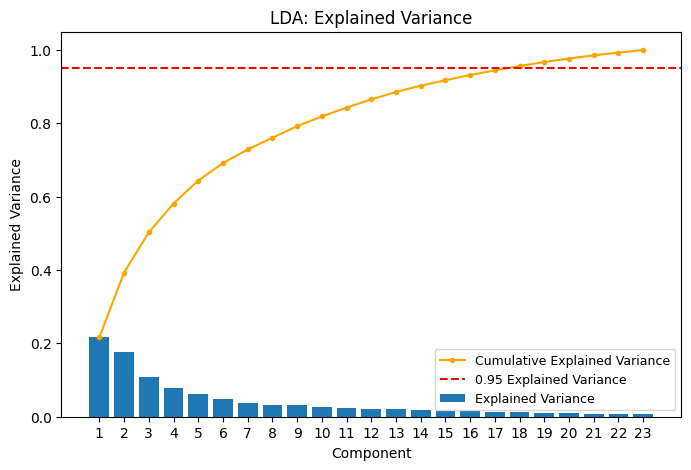

In [24]:
#getting explained variance ratio from the lda model 
evr = lda.explained_variance_ratio_
components = range(1, len(evr) + 1)

#plotting scree plot
fig, ax = plt.subplots(figsize = (8,5))
ax.bar(x = components, height = evr, label = 'Explained Variance');
plt.plot(components, np.cumsum(evr), marker = '.', color = 'orange', label = 'Cumulative Explained Variance')
plt.axhline(y = .95, color = 'r', linestyle = '--', label = '0.95 Explained Variance')
plt.xticks(range(1, len(evr)+1));
plt.title('LDA: Explained Variance');
plt.xlabel('Component');
plt.ylabel('Explained Variance');
plt.legend(fontsize = 9);

Looking at the plot above, it can be interpreted that there is an elbow at around component 3 - 5, however, this would only account for about .4 - .55 of the cumulative variance explained. As a result, for the purposes of modeling, all components resulted from the LDA computation will be used. 

This results in a dimensionality reduction of 784 to 23. 

In [25]:
#fit on training data and transform
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

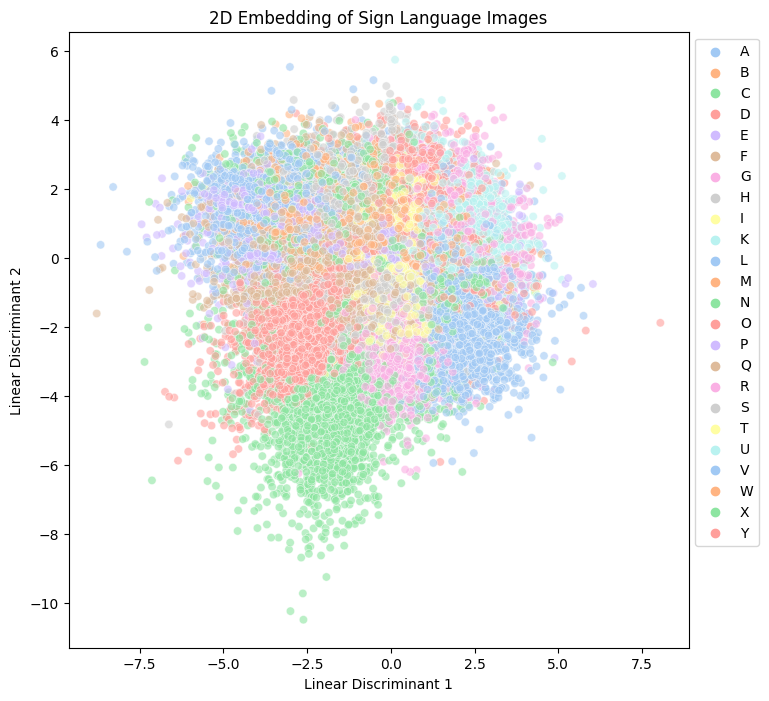

In [26]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.scatterplot(x = X_train_lda[:,0], y = X_train_lda[:,1], hue = y_train, palette = 'pastel',alpha=.6);
handler, _ = ax.get_legend_handles_labels();
plt.legend(handler, letters, bbox_to_anchor = (1, 1));
plt.title('2D Embedding of Sign Language Images')
plt.xlabel('Linear Discriminant 1');
plt.ylabel('Linear Discriminant 2');

Plotting components 1 and 2 from the LDA computation, it is observed that it does reasonably well at separating certain letters from others. For example, X and Y is separated well from the other letters using the first two linear discriminants. The other letters likely require more components to result in a clearer separation between the classes.

#### Modeling with Random Forest

Hyperparameter tuning is an important step in modeling, where the values chosen for a model's hyperparameters can drastically change the performance of the model. Grid Search CV and Randomized Grid Search are methods to find the optimal values that results in the best performing model. 

Grid Search is an exhaustive search algorithm that tries every combination of each set of hyperparameters, and determines which results in the best model. Randomized Grid Search randomly chooses combinations of hyperarameters, which results in less computational requirments but does not guarantee the best performing model is found. However, with a sufficiently high n_iter value, it is likely a close to best performing model is found. 

For this investigation, randomized search will be used. 

In [27]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [ ]:
# Create a Random Forest classifier object
rfc = RandomForestClassifier()

# Create a RandomizedSearchCV object
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, n_iter = 100, cv = 5, random_state=42)

# Fit the RandomizedSearchCV object to the data
rfc_random.fit(X_train, y_train)

In [ ]:
# Print the best hyperparameters
print(rfc_random.best_params_)

In [ ]:
#dumping randomized search cv into pickle file 
with open('/content/svm_randomized_search_cv.pkl','wb') as f:
  pickle.dump(search_lda,f)

The best performing model has the following parameters: {'kernel': 'rbf', 'gamma': 'auto', 'C': 2.6389473684210527}. 

In [ ]:
#display randomized search results 
pd.DataFrame(search_lda.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,48.857509,9.203732,33.812733,6.307010,sigmoid,scale,5.793684,"{'kernel': 'sigmoid', 'gamma': 'scale', 'C': 5...",0.264342,0.263249,0.498998,0.639501,0.650337,0.463285,0.171411,9
1,76.664910,13.098485,31.117175,6.553151,rbf,auto,2.638947,"{'kernel': 'rbf', 'gamma': 'auto', 'C': 2.6389...",0.455290,0.449827,0.735567,0.998634,0.999363,0.727736,0.244413,1
2,389.728341,100.206102,19.843529,4.238948,linear,scale,8.422632,"{'kernel': 'linear', 'gamma': 'scale', 'C': 8....",0.375159,0.373611,0.687762,0.979785,0.983610,0.679985,0.271629,7
3,55.835585,8.530003,37.986475,4.330063,sigmoid,auto,6.319474,"{'kernel': 'sigmoid', 'gamma': 'auto', 'C': 6....",0.242943,0.235840,0.428884,0.547897,0.556183,0.402349,0.140491,10
4,67.057497,13.646386,28.560697,6.103911,rbf,scale,6.319474,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 6.319...",0.453014,0.448825,0.729375,0.998634,0.999180,0.725806,0.245078,2
5,56.344728,10.570659,21.329634,3.880433,linear,auto,0.01,"{'kernel': 'linear', 'gamma': 'auto', 'C': 0.01}",0.371517,0.374158,0.685850,0.979148,0.983427,0.678820,0.272135,8
6,79.955754,14.662078,18.531889,3.737042,poly,scale,3.164737,"{'kernel': 'poly', 'gamma': 'scale', 'C': 3.16...",0.385813,0.375706,0.697778,0.996449,0.996540,0.690457,0.275408,5
7,69.335164,14.177742,17.142364,3.582695,poly,auto,6.319474,"{'kernel': 'poly', 'gamma': 'auto', 'C': 6.319...",0.408213,0.407212,0.708614,0.998452,0.997632,0.704025,0.264014,3
8,81.570674,19.579337,19.994627,4.010486,linear,scale,0.535789,"{'kernel': 'linear', 'gamma': 'scale', 'C': 0....",0.375159,0.374249,0.687489,0.979785,0.983883,0.680113,0.271545,6
9,72.130835,14.146909,17.620427,3.770095,poly,scale,9.474211,"{'kernel': 'poly', 'gamma': 'scale', 'C': 9.47...",0.401930,0.401930,0.707521,0.997997,0.997906,0.701457,0.266566,4


In [ ]:
#best model
search_lda.best_params_

{'kernel': 'rbf', 'gamma': 'auto', 'C': 2.6389473684210527}

In [ ]:
#define svm with best parameters
svm = SVC(kernel = 'rbf', gamma = 'auto', C = 2.6389473684210527)
#fit on training data 
svm.fit(X_train_lda,y_train)
#predict on training data 
y_pred_train = svm.predict(X_train_lda)
#predict on testing data
y_pred_test = svm.predict(X_test_lda)

In [ ]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      2252
         1.0       0.83      0.90      0.86      2020
         2.0       0.97      0.95      0.96      2288
         3.0       0.83      0.83      0.83      2392
         4.0       0.87      0.87      0.87      1914
         5.0       0.89      0.88      0.89      2408
         6.0       0.92      0.89      0.91      2180
         7.0       0.92      0.89      0.90      2026
         8.0       0.80      0.86      0.83      2324
        10.0       0.86      0.85      0.86      2228
        11.0       0.87      0.89      0.88      2482
        12.0       0.87      0.82      0.85      2110
        13.0       0.86      0.85      0.85      2302
        14.0       0.95      0.95      0.95      2392
        15.0       0.96      0.95      0.95      2176
        16.0       0.96      0.96      0.96      2558
        17.0       0.75      0.80      0.78      2588
        18.0       0.84    

In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.50      0.67      0.57       662
         1.0       0.65      0.63      0.64       864
         2.0       0.78      0.78      0.78       620
         3.0       0.45      0.56      0.50       490
         4.0       0.65      0.54      0.59       996
         5.0       0.47      0.65      0.55       494
         6.0       0.56      0.45      0.50       696
         7.0       0.80      0.56      0.66       872
         8.0       0.38      0.40      0.39       576
        10.0       0.50      0.47      0.48       662
        11.0       0.52      0.66      0.58       418
        12.0       0.50      0.32      0.39       788
        13.0       0.32      0.28      0.30       582
        14.0       0.65      0.50      0.57       492
        15.0       0.64      0.57      0.60       694
        16.0       0.38      0.72      0.50       328
        17.0       0.08      0.19      0.11       288
        18.0       0.21    

Dataset: 100k training augmented dataset. 

Fitting on the 100k training augmented dataset shows improvement. The training accuracy changed from .87 to .89 and the testing accuracy changes from .49 to .68. This shows an improvement in the overfitting concerns. However, the time for computation is significantly higher, even only using 23 linear discriminant components. 

In [ ]:
#opening pickle file of augmented added data
with open('/content/drive/Shareddrives/SignLanguageData/combined_augmented_data_v2.pkl','rb') as f:
    X_train,y_train,X_test,y_test = pickle.load(f)

In [ ]:
#standardized data 
#using sklearn standard scaler model and fitting on training data 
sc = StandardScaler().fit(X_train.reshape(X_train.shape[0],-1))
X_train = sc.transform(X_train.reshape(X_train.shape[0],-1))
X_test = sc.transform(X_test.reshape(X_test.shape[0],-1))

In [ ]:
#define sklearn LDA object 
lda = LinearDiscriminantAnalysis()
#fit on training data 
lda.fit(X_train,y_train)

LinearDiscriminantAnalysis()

In [ ]:
#dump lda model into pickle 
with open('/content/drive/Shareddrives/SignLanguageData/pickle_project_content/lda_100k_aug.pkl','wb') as f:
  pickle.dump(lda,file=f)

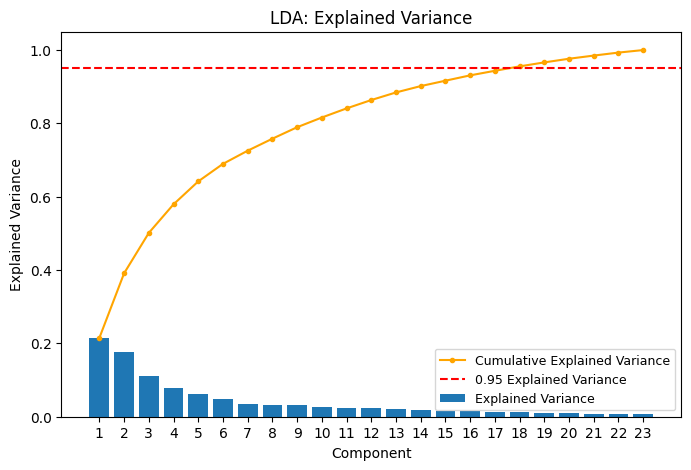

In [ ]:
#getting explained variance ratio from the lda model 
evr = lda.explained_variance_ratio_
components = range(1, len(evr) + 1)

#plotting scree plot
fig, ax = plt.subplots(figsize = (8,5))
ax.bar(x = components, height = evr, label = 'Explained Variance');
plt.plot(components, np.cumsum(evr), marker = '.', color = 'orange', label = 'Cumulative Explained Variance')
plt.axhline(y = .95, color = 'r', linestyle = '--', label = '0.95 Explained Variance')
plt.xticks(range(1, len(evr)+1));
plt.title('LDA: Explained Variance');
plt.xlabel('Component');
plt.ylabel('Explained Variance');
plt.legend(fontsize = 9);

In [ ]:
#fit on training data and transform
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

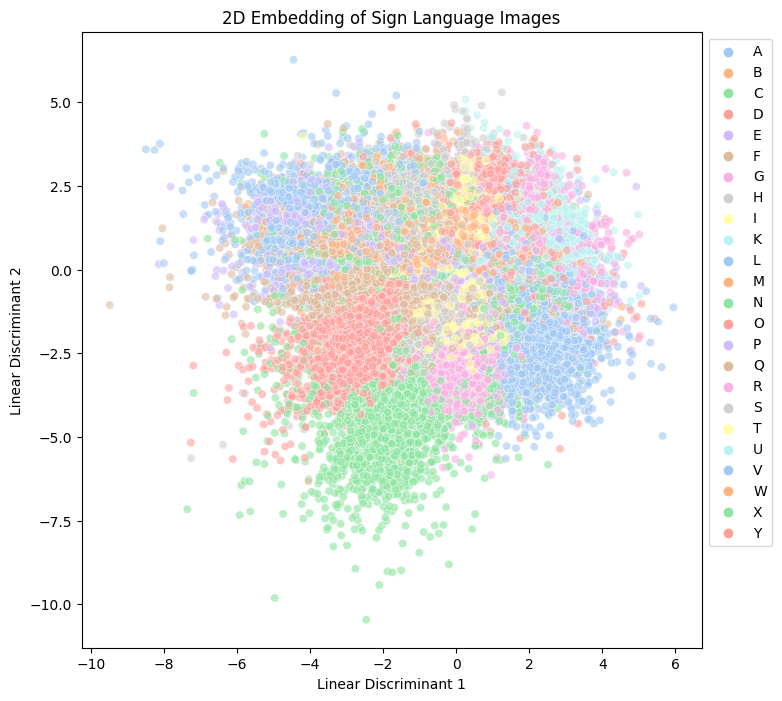

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))
ax = sns.scatterplot(x = X_train_lda[:,0], y = X_train_lda[:,1], hue = y_train, palette = 'pastel',alpha=.6);
handler, _ = ax.get_legend_handles_labels();
plt.legend(handler, letters, bbox_to_anchor = (1, 1));
plt.title('2D Embedding of Sign Language Images')
plt.xlabel('Linear Discriminant 1');
plt.ylabel('Linear Discriminant 2');

In [ ]:
#define svm with best parameters
svm = SVC(kernel = 'rbf', gamma = 'auto', C = 2.6389473684210527)
#fit on training data 
svm.fit(X_train_lda,y_train)
#predict on training data 
y_pred_train = svm.predict(X_train_lda)
#predict on testing data
y_pred_test = svm.predict(X_test_lda)

In [ ]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90      4504
         1.0       0.90      0.94      0.92      4040
         2.0       0.98      0.97      0.97      4576
         3.0       0.87      0.86      0.86      4784
         4.0       0.90      0.88      0.89      3828
         5.0       0.91      0.90      0.91      4816
         6.0       0.96      0.94      0.95      4360
         7.0       0.95      0.94      0.95      4052
         8.0       0.84      0.90      0.87      4648
        10.0       0.89      0.87      0.88      4456
        11.0       0.90      0.91      0.91      4964
        12.0       0.88      0.83      0.86      4220
        13.0       0.85      0.86      0.86      4604
        14.0       0.98      0.97      0.97      4784
        15.0       0.99      0.98      0.98      4352
        16.0       0.98      0.98      0.98      5116
        17.0       0.77      0.81      0.79      5176
        18.0       0.85    

In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75      1324
         1.0       0.85      0.78      0.82      1728
         2.0       0.91      0.87      0.89      1240
         3.0       0.58      0.62      0.60       980
         4.0       0.79      0.71      0.75      1992
         5.0       0.66      0.76      0.71       988
         6.0       0.74      0.70      0.72      1392
         7.0       0.90      0.78      0.84      1744
         8.0       0.62      0.70      0.66      1152
        10.0       0.72      0.61      0.66      1324
        11.0       0.69      0.78      0.73       836
        12.0       0.68      0.58      0.63      1576
        13.0       0.53      0.55      0.54      1164
        14.0       0.87      0.77      0.81       984
        15.0       0.93      0.87      0.90      1388
        16.0       0.64      0.91      0.75       656
        17.0       0.22      0.40      0.29       576
        18.0       0.44    

In [ ]:
#dumping into pickle 
svm_content = (svm,y_pred_train,y_pred_test)
with open('/content/drive/Shareddrives/SignLanguageData/SVMModel_TrainTestPredictions.pkl','wb') as f:
  pickle.dump(svm_content,file=f)

Letter R performs significantly worse than the other letters. Inspecting R examples directly. 

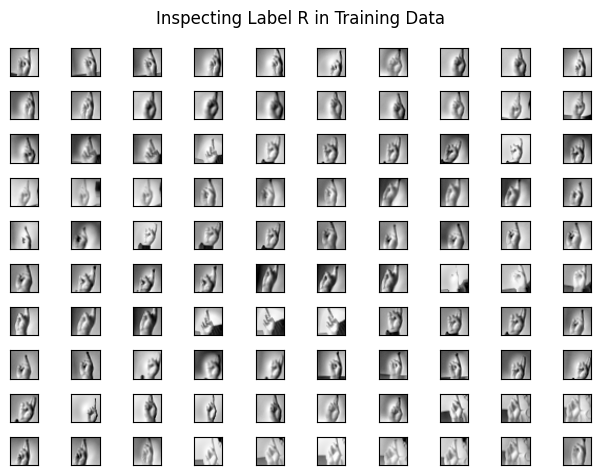

In [ ]:
#fuction to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')

#visualization of dataset 
fig, ax = plt.subplots(10,10)
plt.suptitle('Inspecting Label R in Training Data')
ax = ax.ravel()
pos = 0 

label = 17

index = find_indices(y_train,label)[0]

#loop through each label in dataset 
for i, idx in enumerate(index):
    if i >= 100:
        break
    #display first found image 
    ax[pos].imshow(X_train[idx].reshape(28,28),cmap='gray')
    #do not show ticks 
    ax[pos].set_xticks([])
    ax[pos].set_yticks([])
    #increment for subplotting 
    pos+=1

plt.tight_layout()
plt.show()